In [1]:
from py2neo import Graph
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# graph = Graph("bolt://<IP Address>:<Bolt Port>", auth=("neo4j", "<Password>")) 
graph = Graph("bolt://54.237.31.61:39022", auth=('neo4j', 'wholesales-formulas-set'))

In [ ]:
graph.run("CALL db.schema()").data()

In [ ]:
result = {"label":[], "count":[]}
for label in graph.run('CALL db.labels()').to_series():
    query = "MATCH (: {}) RETURN count(*) AS count".format(label)
    
    count = graph.run(query).to_data_frame().iloc[0]['count']   #Running above query
    
    result['label'].append(label)
    result['count'].append(count)
  
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values('count')

In [ ]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None)
plt.yscale('log')      #As Geo_Location has 10 times more nodes so we need to use log to balance
plt.xlabel('label', fontsize=12)
plt.ylabel('Log scaled number of nodes', fontsize=10)
plt.title('Count Per Label', fontsize=13)
plt.tight_layout()     #stretches the plot width wise
plt.savefig('barplot_count_per_label.png')
plt.show()

In [ ]:
result = {'relation_type':[], 'count':[]}
for relation_type in graph.run('CALL db.relationshipTypes()').to_series():
    query = "MATCH ()-[:{}]->() RETURN count(*) AS count".format(relation_type)
    
    count = graph.run(query).to_data_frame().iloc[0]['count']    #Running above query
    
    result['relation_type'].append(relation_type)
    result['count'].append(count)
    
relationships_df = pd.DataFrame(data=result)
relationships_df.sort_values('count')

In [ ]:
relationships_df.plot(kind='bar', x='relation_type', y='count', legend=None, title='Count per Relationships')
plt.xticks(rotation=60)
plt.xlabel('Relation Type', fontsize=13)
plt.ylabel('Number of Nodes', fontsize=13)
plt.title('Count Per Relationships', fontsize=15)
plt.tight_layout()    #Strech widthwise
plt.savefig('barplot_count_per_relationships.png')
plt.show()

In [ ]:
product_customers = graph.run("MATCH(c:Customer)-[ORDERED]->(o:Order)-[ITEM]->(o_it:Order_Item)-[PRODUCT]->(p:Product)-[PART_OF]->(cat:Product_Category) RETURN cat.category_name_english AS product_category, COUNT(c.unique_id) AS total_customers limit 10").to_data_frame().sort_values('total_customers')
product_customers.plot(kind='barh', x='product_category', y='total_customers', figsize=[70, 50], legend=None)
plt.suptitle('Total Customers per Each Product Category', fontsize=60)
plt.xlabel('Amount of Orders', fontsize=60, labelpad=30)
plt.ylabel('Product Category', fontsize=60)
plt.xticks(fontsize=45)
plt.yticks(fontsize=45)
plt.savefig('barplot_total_customers_per_each_product_category.png')
plt.show()

In [ ]:
orders_per_customers = graph.run("MATCH (o:Order)<--(c:Customer)-->(g:Geo_Location) RETURN g.state AS state, COUNT(c) AS total_customers limit 10").to_data_frame().sort_values('total_customers')
orders_per_customers.plot(kind='barh', x='state', y='total_customers', figsize=[100, 100], legend=None)
plt.title('Total Orders Per Customers of Each State', fontsize=65)
plt.xlabel('Total Orders Per Customers', fontsize=85, labelpad=50)
plt.ylabel('States', fontsize=85, labelpad=50)
plt.xticks(fontsize=80)
plt.yticks(fontsize=80)
plt.savefig('barplot_total_orders_per_customers_per_state.png')
plt.show()

In [ ]:
orders_by_sellers = graph.run("MATCH (o_it:Order_Item)<--(s:Seller)-->(g:Geo_Location) RETURN g.state AS state, COUNT(o_it) AS total_orders").to_data_frame().sort_values('total_orders').iloc[0:5]
orders_by_sellers.plot(kind='bar', x='state', y='total_orders', figsize=[100, 100], legend=None)
plt.title('Total Orders Per Sellers of Each State', fontsize=100)
plt.xlabel('States', fontsize=75)
plt.ylabel('Orders Per Sellers', fontsize=75)
plt.xticks(fontsize=120, rotation=360)
plt.yticks(fontsize=120)
plt.savefig('barplot_total_orders_per_sellers_per_state.png')
plt.show()

In [ ]:
number_of_installments = graph.run("MATCH (p:Payment) RETURN p.installments AS installments").to_data_frame()
number_of_installments.hist()
plt.ylabel('Per Customers')
plt.savefig('histogram_number_of_installments.png')
plt.show()

In [ ]:
ordered_price = graph.run("MATCH (p:Payment) RETURN p.order_id AS order_id, p.value AS price").to_data_frame()
ordered_price.boxplot()
plt.savefig('boxplot_price.png')
plt.show()

In [3]:
total_order_val = graph.run("MATCH (o:Order)-->(o_it:Order_Item) RETURN o_it.price*count(o_it.order_id)+o_it.freight_value*count(o_it.order_id) AS total_order_value, o.delivered_customer_date AS delivered_customer_date").to_data_frame()
total_order_val.head()

,delivered_customer_date,total_order_value
0,2017-09-05 17:03:03,97.87
1,2017-07-11 17:07:42,70.14
2,2018-05-07 21:58:31,37.22
3,2017-08-08 21:52:13,46.28
4,2018-03-05 21:43:52,162.55


In [9]:
total_order_val.info()   #delivered_customer_date is object string,so need to convert it

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101371 entries, 2017-09-05 17:03:03 to 2018-06-14 17:56:26
Data columns (total 1 columns):
total_order_value    101371 non-null float64
dtypes: float64(1)
memory usage: 1.5 MB


In [8]:
total_order_val['delivered_customer_date'] = pd.DatetimeIndex(total_order_val['delivered_customer_date'])
total_order_val = total_order_val.set_index('delivered_customer_date')
total_order_val.info()

KeyError: 'delivered_customer_date'

In [12]:
total_order_val_grp_year = total_order_val.groupby(by=[total_order_val.index.year]).mean()   #Finding average total_order per year 
total_order_val_grp_month = total_order_val.groupby(by=[total_order_val.index.month]).mean()   #Finding average total_order per year 

,total_order_value
delivered_customer_date,
1.0,145.522221
2.0,149.212753
3.0,151.844214
4.0,161.258456
5.0,158.230647


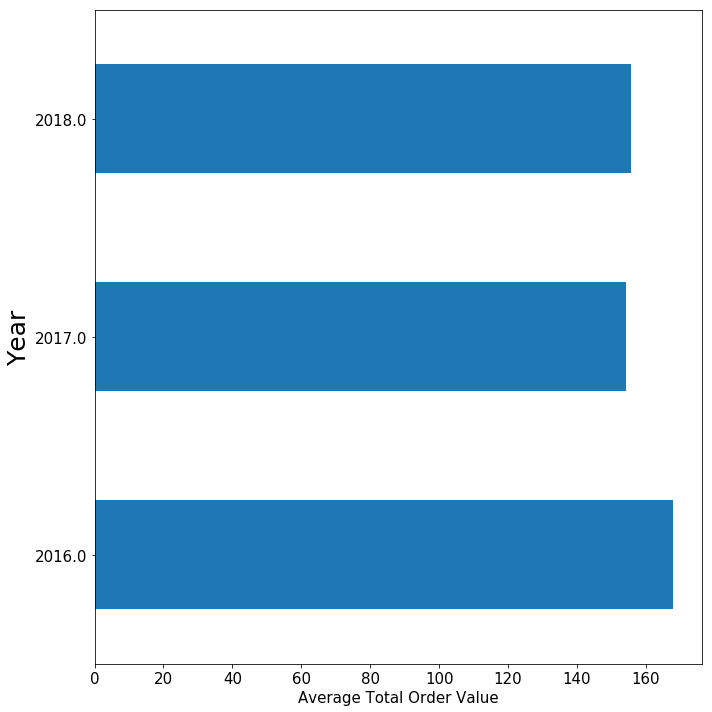

In [16]:
total_order_val_grp_year.plot(kind='barh', figsize=[10,10], legend=None)
plt.xlabel('Average Total Order Value', fontsize=15)
plt.ylabel('Year', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('avg_total_order_per_year.png')
plt.tight_layout()

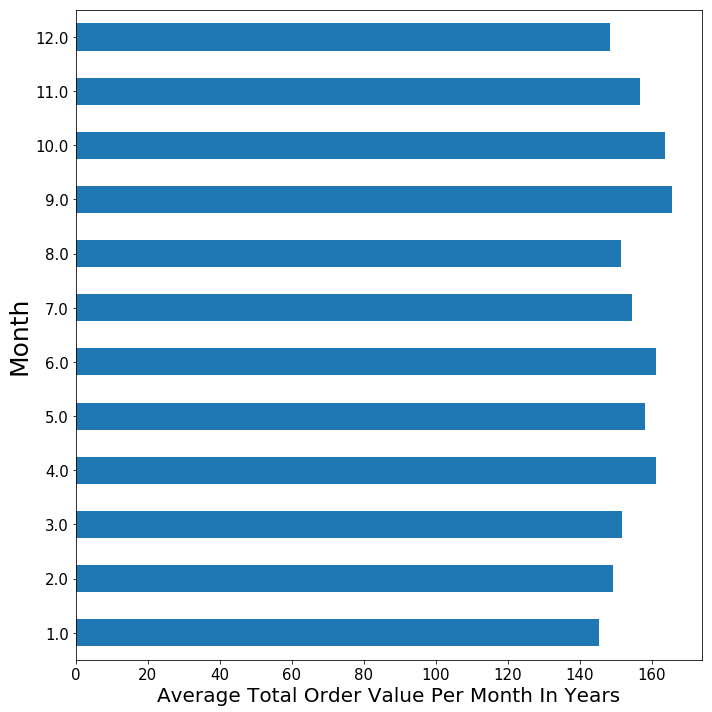

In [20]:
total_order_val_grp_month.plot(kind='barh', figsize=[10,10], legend=None)
plt.xlabel('Average Total Order Value Per Month In Years', fontsize=20)
plt.ylabel('Month', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('avg_total_order_per_month.png')
plt.tight_layout()

In [21]:
total_orders = graph.run("MATCH (o:Order) RETURN o.delivered_customer_date AS delivered_customer_date, count(*) AS num_orders").to_data_frame()
print(total_orders.head())
print('\n')
total_orders.info()   #date is string so should convert it

  delivered_customer_date  num_orders
0     2017-10-10 21:25:13           1
1     2018-08-07 15:27:45           1
2     2018-08-17 18:06:29           1
3     2017-12-02 00:28:42           1
4     2018-02-16 18:17:02           1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95665 entries, 0 to 95664
Data columns (total 2 columns):
delivered_customer_date    95664 non-null object
num_orders                 95665 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [22]:
total_orders['delivered_customer_date'] = pd.DatetimeIndex(total_orders['delivered_customer_date'])
total_orders = total_orders.set_index('delivered_customer_date')
total_orders_grp_year = total_orders.groupby(by=[total_orders.index.year]).sum()
total_orders_grp_year.head()

,num_orders
delivered_customer_date,
2016.0,272
2017.0,40930
2018.0,55274


In [24]:
total_orders_grp_month = total_orders.groupby(by=[total_orders.index.month]).sum()
total_orders_grp_month.head()

,num_orders
delivered_customer_date,
1.0,6880
2.0,7201
3.0,9207
4.0,9699
5.0,10862


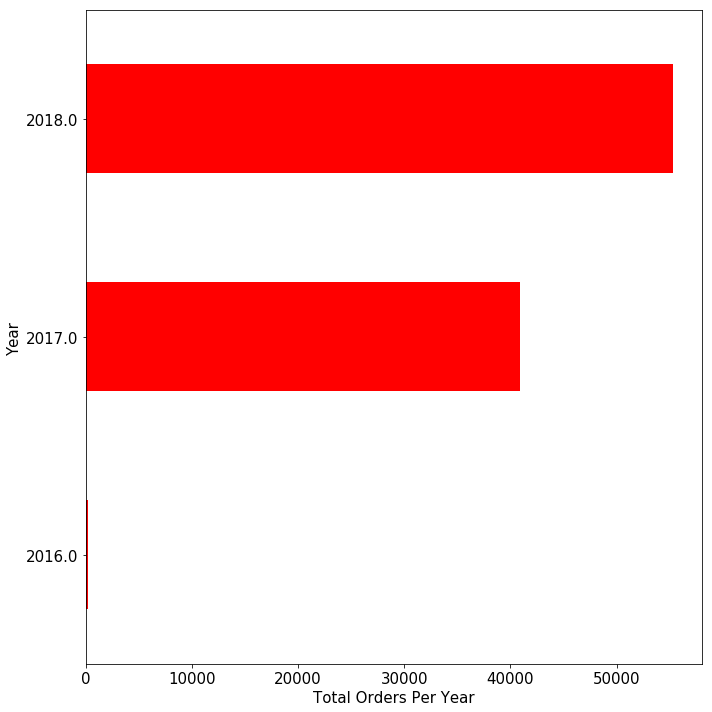

In [26]:
total_orders_grp_year.plot(kind='barh', figsize=[10,10], legend=None, colormap='rainbow_r')
plt.xlabel('Total Orders Per Year', fontsize=15)
plt.ylabel('Year', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('total_orders_per_year.png')
plt.tight_layout()

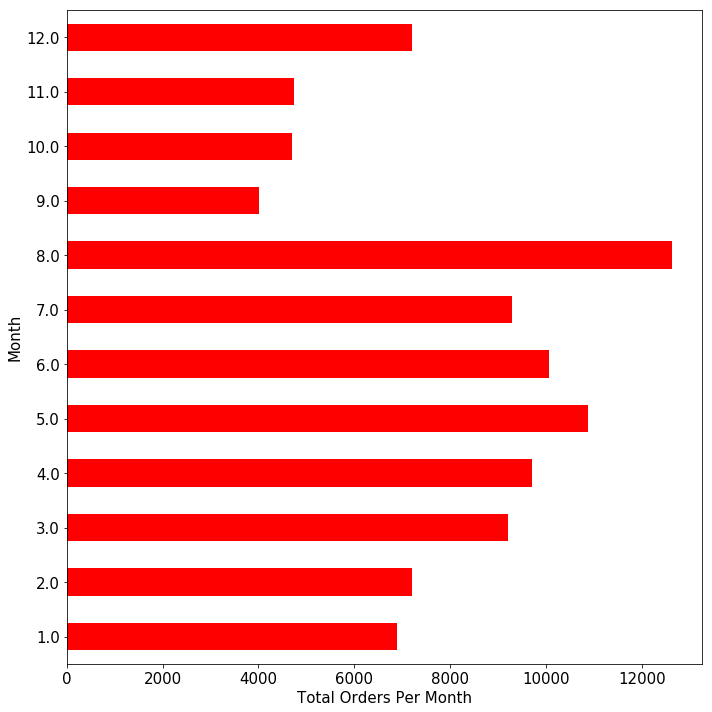

In [28]:
total_orders_grp_month.plot(kind='barh', figsize=[10,10], legend=None, colormap='rainbow_r')
plt.xlabel('Total Orders Per Month', fontsize=15)
plt.ylabel('Month', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('total_orders_per_month.png')
plt.tight_layout()